<a href="https://colab.research.google.com/github/BDafflon/CPS-Manager/blob/master/Copie_de_Untitled6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

#DataSet

In [ ]:
time = np.arange(0, 100, 0.1)
dataSin = np.sin(time) + np.random.normal(scale=0.5, size=len(time))

#DataFrame

In [ ]:
data = pd.DataFrame({'Sin':dataSin})
data.head()

,Sin
0,-0.521236
1,0.202324
2,-0.336423
3,0.571969
4,-0.353863


#Affichage DataSet

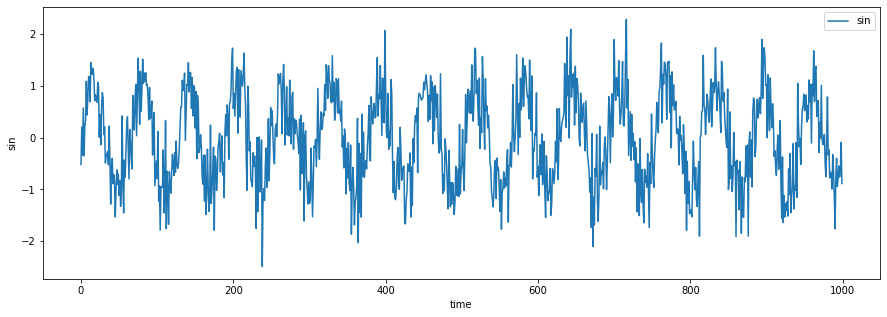

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(data, label = "sin")
plt.xlabel("time")
plt.ylabel("sin")

plt.legend()
plt.show()

#Conversion


In [ ]:
data_raw = data.values.astype("float32")


scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)


#Separation TrainingSet / ValidationSet

In [ ]:
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]


#Keras format

In [ ]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [ ]:
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))


#LSTM modele (ultra simple)

In [ ]:
def fit_model(train_X, train_Y, window_size = 1, epoch=20,batch_size=1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = epoch, 
              batch_size = batch_size, 
              verbose = 2)
    
    return(model)

#Entrainement

In [ ]:
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/20
 - 1s - loss: 0.0688
Epoch 2/20
 - 1s - loss: 0.0213
Epoch 3/20
 - 1s - loss: 0.0201
Epoch 4/20
 - 1s - loss: 0.0191
Epoch 5/20
 - 1s - loss: 0.0186
Epoch 6/20
 - 1s - loss: 0.0182
Epoch 7/20
 - 1s - loss: 0.0181
Epoch 8/20
 - 1s - loss: 0.0180
Epoch 9/20
 - 1s - loss: 0.0181
Epoch 10/20
 - 1s - loss: 0.0180
Epoch 11/20
 - 1s - loss: 0.0179
Epoch 12/20
 - 1s - loss: 0.0181
Epoch 13/20
 - 1s - loss: 0.0179
Epoch 14/20
 - 1s - loss: 0.0180
Epoch 15/20
 - 1s - loss: 0.0181
Epoch 16/20
 - 1s - loss: 0.0180
Epoch 17/20
 - 1s - loss: 0.0180
Epoch 18/20
 - 1s - loss: 0.0180
Epoch 19/20
 - 1s - loss: 0.0180
Epoch 20/20
 - 1s - loss: 0.0181


#Prediction

In [ ]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)



In [ ]:
rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)


#Affichage

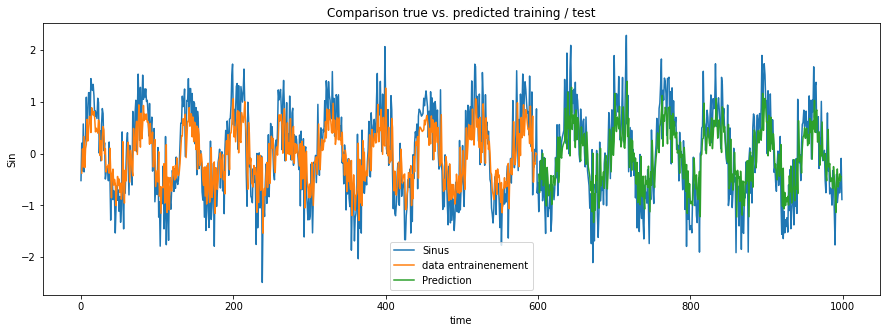

In [ ]:
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "Sinus")
plt.plot(train_predict_plot, label = "data entrainenement")
plt.plot(test_predict_plot, label = "Prediction")
plt.xlabel("time")
plt.ylabel("Sin")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()